In [3]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import sys
import os
from Manifold_Analysis import Manifold_analysis
sys.path.append('../../../')
from algos.agents import A2CAgent
from algos.models import ActorCnn, CriticCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

from matplotlib.ticker import NullFormatter
from collections import OrderedDict
from functools import partial
from sklearn import manifold, datasets

import cv2

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [4]:
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

## Init GPU or CPU

In [5]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Create Environment

In [6]:
#env = gym.make('SpaceInvaders-v0',render_mode='human')
env = gym.make('SpaceInvaders-v0')


env.seed(0)

def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


## Create Agent

In [7]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0005          # Critic learning rate
UPDATE_EVERY = 100     # how often to update the network 


epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

start_epoch = 0
scores = []
scores_window = deque(maxlen=20)
length_trial = 500

In [8]:


agent_init = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)
agent_1000 = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)
agent_2000 = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)
agent_3000 = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)
agent_4000 = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)
agent_5000 = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)





Liste_agents = {
    "agent_a2c_init" : agent_init,
    "agent_a2c_1000" : agent_1000,
    "agent_a2c_2000" : agent_2000,
    "agent_a2c_3000" : agent_3000,
    "agent_a2c_4000" : agent_4000,
    "agent_a2c_5000" : agent_5000,
}



## Load Agents corresponding to different part of the training

In [9]:
for a in Liste_agents.keys():
    if a != "agent_a2c_init":
        
        PATH = os.path.join(os.getcwd(),"Models_training_a2c_space_invader",a+ ".pt")
        print(PATH)
        checkpoint = torch.load(PATH , map_location=torch.device('cpu'))
        Liste_agents[a].actor_net.load_state_dict(checkpoint['modelA_state_dict'])
        Liste_agents[a].critic_net.load_state_dict(checkpoint['modelB_state_dict'])
        Liste_agents[a].actor_optimizer.load_state_dict(checkpoint['optimizerA_state_dict'])
        Liste_agents[a].critic_optimizer.load_state_dict(checkpoint['optimizerB_state_dict'])


/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_1000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_2000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_3000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_4000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_5000.pt


In [69]:
Names_hook = ["Conv_1","Conv_2","Conv_3","fc1"]
EPISODES = 100
Liste_activation = [[[[] for i in range(len(Names_hook))] for j in range(len( Liste_agents))] for episode in range(EPISODES)]
i = 0
Final_score = [[[] for j in range(len( Liste_agents))] for episode in range(EPISODES)]

for episode in range(EPISODES):
    agent_number = 0
    for agent in Liste_agents.values():
        while i < length_trial:
            agent.registration()
            score = 0
            #print(Liste_activation[agent_number])
            
            Liste_activation[episode][agent_number] = [[] for i in range(len(Names_hook))]
            state = stack_frames(None, env.reset(), True)
            i = 0
            while True:
                #env.render()
                action, _, _ = agent.act(state)

                for h in range(len(Names_hook)):
                    Liste_activation[episode][agent_number][h].append(torch.flatten(agent.activation[Names_hook[h]]))  # If concatenate list directly with Liste_activation[agent_number][h] += torch.flatten(agent.activation[Names_hook[h]]) takes much more time

                next_state, reward, done, _ = env.step(action)
                score += reward
                state = stack_frames(state, next_state, False)
                i+=1
                if done:
                    print('\nEpisode :{} \tAgent number :{} \tFinal score: {:.2f} \tNumber of steps: {}'.format(episode,agent_number, score,i), end="")
                    
                    break 
            env.close()


            agent.detach()
        i = 0  
        Final_score[episode][agent_number].append(score)

        agent_number += 1
#Final_score= (np.array(Final_score))[:,:,0]

        

    


Episode :0 	Agent number :0 	Final score: 110.00 	Number of steps: 497
Episode :0 	Agent number :0 	Final score: 240.00 	Number of steps: 853
Episode :0 	Agent number :1 	Final score: 260.00 	Number of steps: 1143
Episode :0 	Agent number :2 	Final score: 135.00 	Number of steps: 782
Episode :0 	Agent number :3 	Final score: 210.00 	Number of steps: 801
Episode :0 	Agent number :4 	Final score: 105.00 	Number of steps: 649
Episode :0 	Agent number :5 	Final score: 250.00 	Number of steps: 996
Episode :1 	Agent number :0 	Final score: 180.00 	Number of steps: 861
Episode :1 	Agent number :1 	Final score: 260.00 	Number of steps: 885
Episode :1 	Agent number :2 	Final score: 155.00 	Number of steps: 716
Episode :1 	Agent number :3 	Final score: 120.00 	Number of steps: 702
Episode :1 	Agent number :4 	Final score: 250.00 	Number of steps: 911
Episode :1 	Agent number :5 	Final score: 210.00 	Number of steps: 882
Episode :2 	Agent number :0 	Final score: 50.00 	Number of steps: 415
Episo

Episode :32 	Agent number :3 	Final score: 120.00 	Number of steps: 776
Episode :32 	Agent number :4 	Final score: 265.00 	Number of steps: 960
Episode :32 	Agent number :5 	Final score: 90.00 	Number of steps: 507
Episode :33 	Agent number :0 	Final score: 80.00 	Number of steps: 384
Episode :33 	Agent number :0 	Final score: 60.00 	Number of steps: 573
Episode :33 	Agent number :1 	Final score: 90.00 	Number of steps: 429
Episode :33 	Agent number :1 	Final score: 425.00 	Number of steps: 1125
Episode :33 	Agent number :2 	Final score: 135.00 	Number of steps: 588
Episode :33 	Agent number :3 	Final score: 105.00 	Number of steps: 675
Episode :33 	Agent number :4 	Final score: 135.00 	Number of steps: 765
Episode :33 	Agent number :5 	Final score: 150.00 	Number of steps: 667
Episode :34 	Agent number :0 	Final score: 375.00 	Number of steps: 1079
Episode :34 	Agent number :1 	Final score: 345.00 	Number of steps: 1119
Episode :34 	Agent number :2 	Final score: 155.00 	Number of step

Episode :63 	Agent number :1 	Final score: 65.00 	Number of steps: 540
Episode :63 	Agent number :2 	Final score: 75.00 	Number of steps: 398
Episode :63 	Agent number :2 	Final score: 160.00 	Number of steps: 806
Episode :63 	Agent number :3 	Final score: 210.00 	Number of steps: 817
Episode :63 	Agent number :4 	Final score: 205.00 	Number of steps: 1018
Episode :63 	Agent number :5 	Final score: 160.00 	Number of steps: 822
Episode :64 	Agent number :0 	Final score: 160.00 	Number of steps: 641
Episode :64 	Agent number :1 	Final score: 80.00 	Number of steps: 614
Episode :64 	Agent number :2 	Final score: 85.00 	Number of steps: 602
Episode :64 	Agent number :3 	Final score: 230.00 	Number of steps: 849
Episode :64 	Agent number :4 	Final score: 210.00 	Number of steps: 905
Episode :64 	Agent number :5 	Final score: 50.00 	Number of steps: 427
Episode :64 	Agent number :5 	Final score: 30.00 	Number of steps: 395
Episode :64 	Agent number :5 	Final score: 55.00 	Number of steps: 50

Episode :94 	Agent number :1 	Final score: 125.00 	Number of steps: 565
Episode :94 	Agent number :2 	Final score: 155.00 	Number of steps: 622
Episode :94 	Agent number :3 	Final score: 110.00 	Number of steps: 650
Episode :94 	Agent number :4 	Final score: 240.00 	Number of steps: 984
Episode :94 	Agent number :5 	Final score: 285.00 	Number of steps: 908
Episode :95 	Agent number :0 	Final score: 60.00 	Number of steps: 581
Episode :95 	Agent number :1 	Final score: 110.00 	Number of steps: 566
Episode :95 	Agent number :2 	Final score: 120.00 	Number of steps: 632
Episode :95 	Agent number :3 	Final score: 210.00 	Number of steps: 822
Episode :95 	Agent number :4 	Final score: 680.00 	Number of steps: 1269
Episode :95 	Agent number :5 	Final score: 105.00 	Number of steps: 485
Episode :95 	Agent number :5 	Final score: 285.00 	Number of steps: 882
Episode :96 	Agent number :0 	Final score: 130.00 	Number of steps: 472
Episode :96 	Agent number :0 	Final score: 75.00 	Number of step

In [70]:
analysis = Manifold_analysis(length_trial)

In [72]:
Final_score= np.array(Final_score)
#Final_score = Final_score[:,:,0]
print(Final_score.shape)

(100, 6)


In [73]:
FINAL_SCORE = np.mean(Final_score,axis =0)
print(FINAL_SCORE.shape)
print(FINAL_SCORE)

(6,)
[161.35 163.8  140.25 180.05 251.   198.55]


In [ ]:
activity_layer = [[[[] for i in range(len(Names_hook))] for j in range(len( Liste_agents))] for episode in range(EPISODES)]


for agent_number in range(len(Liste_agents)):
    print("agent_number",agent_number)
    for layer in range(len(Names_hook)):
        for episode in range(EPISODES):
            activity_layer[episode][agent_number][layer] = analysis.prepro(Liste_activation[episode][agent_number][layer])
            
            print(episode)


agent_number 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


## Compute the Isomap

agent_number 0
agent_number 1


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

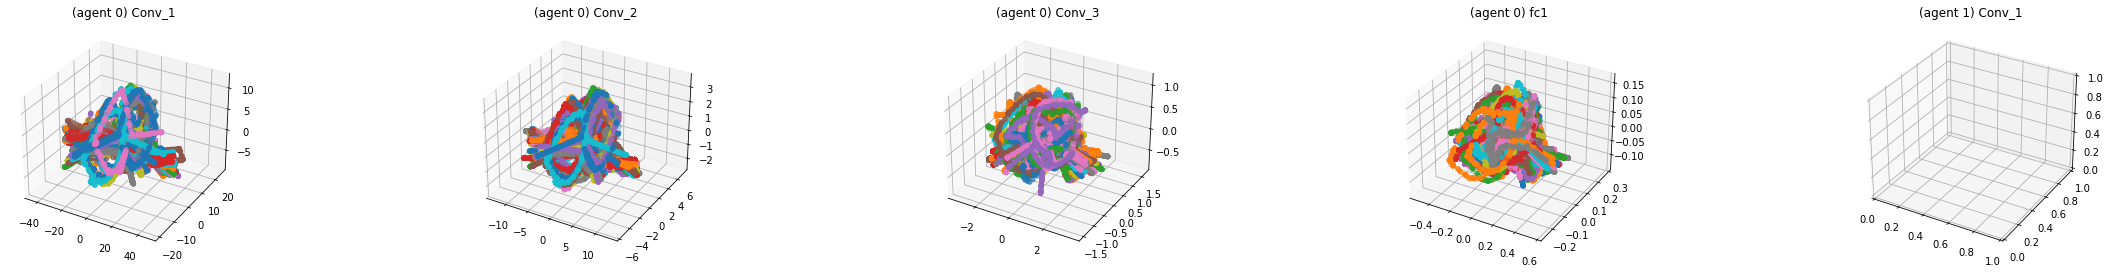

In [77]:
embedding = Isomap(n_neighbors=20,n_components=3)
i = 1
fig = plt.figure(figsize=(40, 30))
for agent_number in range(len(Liste_agents)):
    print("agent_number",agent_number)
    for layer in range(len(Names_hook)):
        ax = fig.add_subplot(len(Liste_agents), len(Names_hook)+1,i,projection='3d')
        #ax.axis("tight")
        ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))
        for episode in range(EPISODES):
            #activity_layer[episode][agent_number][layer] = analysis.prepro(Liste_activation[episode][agent_number][layer])
            X = embedding.fit_transform(activity_layer[episode][agent_number][layer])
            #colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))
            ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
        #ax.view_init(azim=80, elev=30)
        
        i+=1




plt.legend(loc='upper left')
plt.show()



## MDS plot

In [15]:
D = pairwise_distances(activation)
model = MDS(n_components=dimension, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)

NameError: name 'activation' is not defined

agent_number 0


ValueError: Array must be symmetric

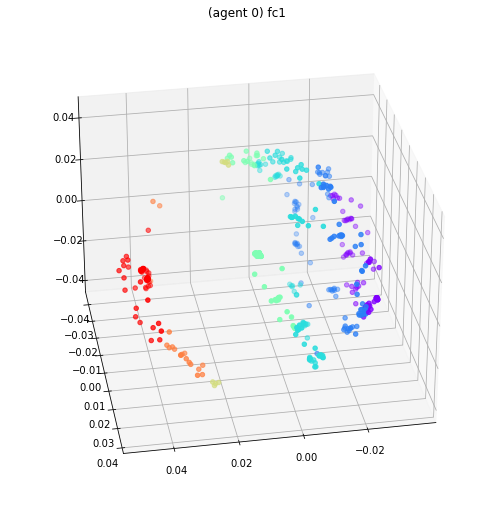

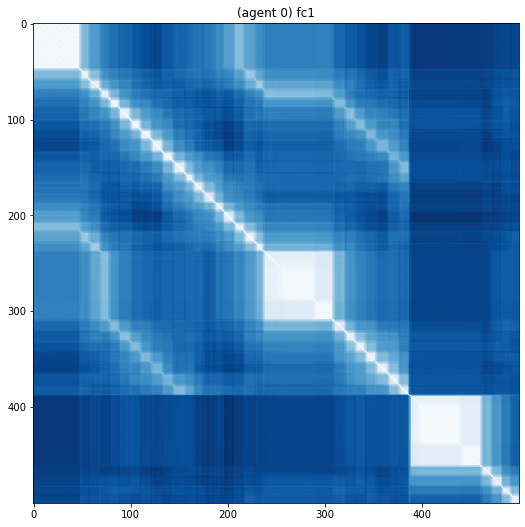

In [20]:

model = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
i = 1
fig = plt.figure(figsize=(40, 30))

fig2 = plt.figure(figsize=(40, 30))
for agent_number in range(len(Liste_agents)):
    print("agent_number",agent_number)
    for layer in range(len(Names_hook)):
        activity_layer = analysis.prepro(Liste_activation[0][agent_number][layer])

        D = pairwise_distances(activity_layer)
        X  = model.fit_transform(D)
        colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))
        ax = fig.add_subplot(len(Liste_agents), len(Names_hook),i,projection='3d')
        sc = ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],**colorize)
        ax.view_init(azim=80, elev=30)
        ax.axis("tight")
        ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))

        ax2 = fig2.add_subplot(len(Liste_agents), len(Names_hook),i)
        ax2.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
        ax2.axis("tight")
        ax2.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))






        i+=1
plt.show()

## t-SNE

agent_number 0


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:79

agent_number 1


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:79

agent_number 2


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:79

agent_number 3


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:79

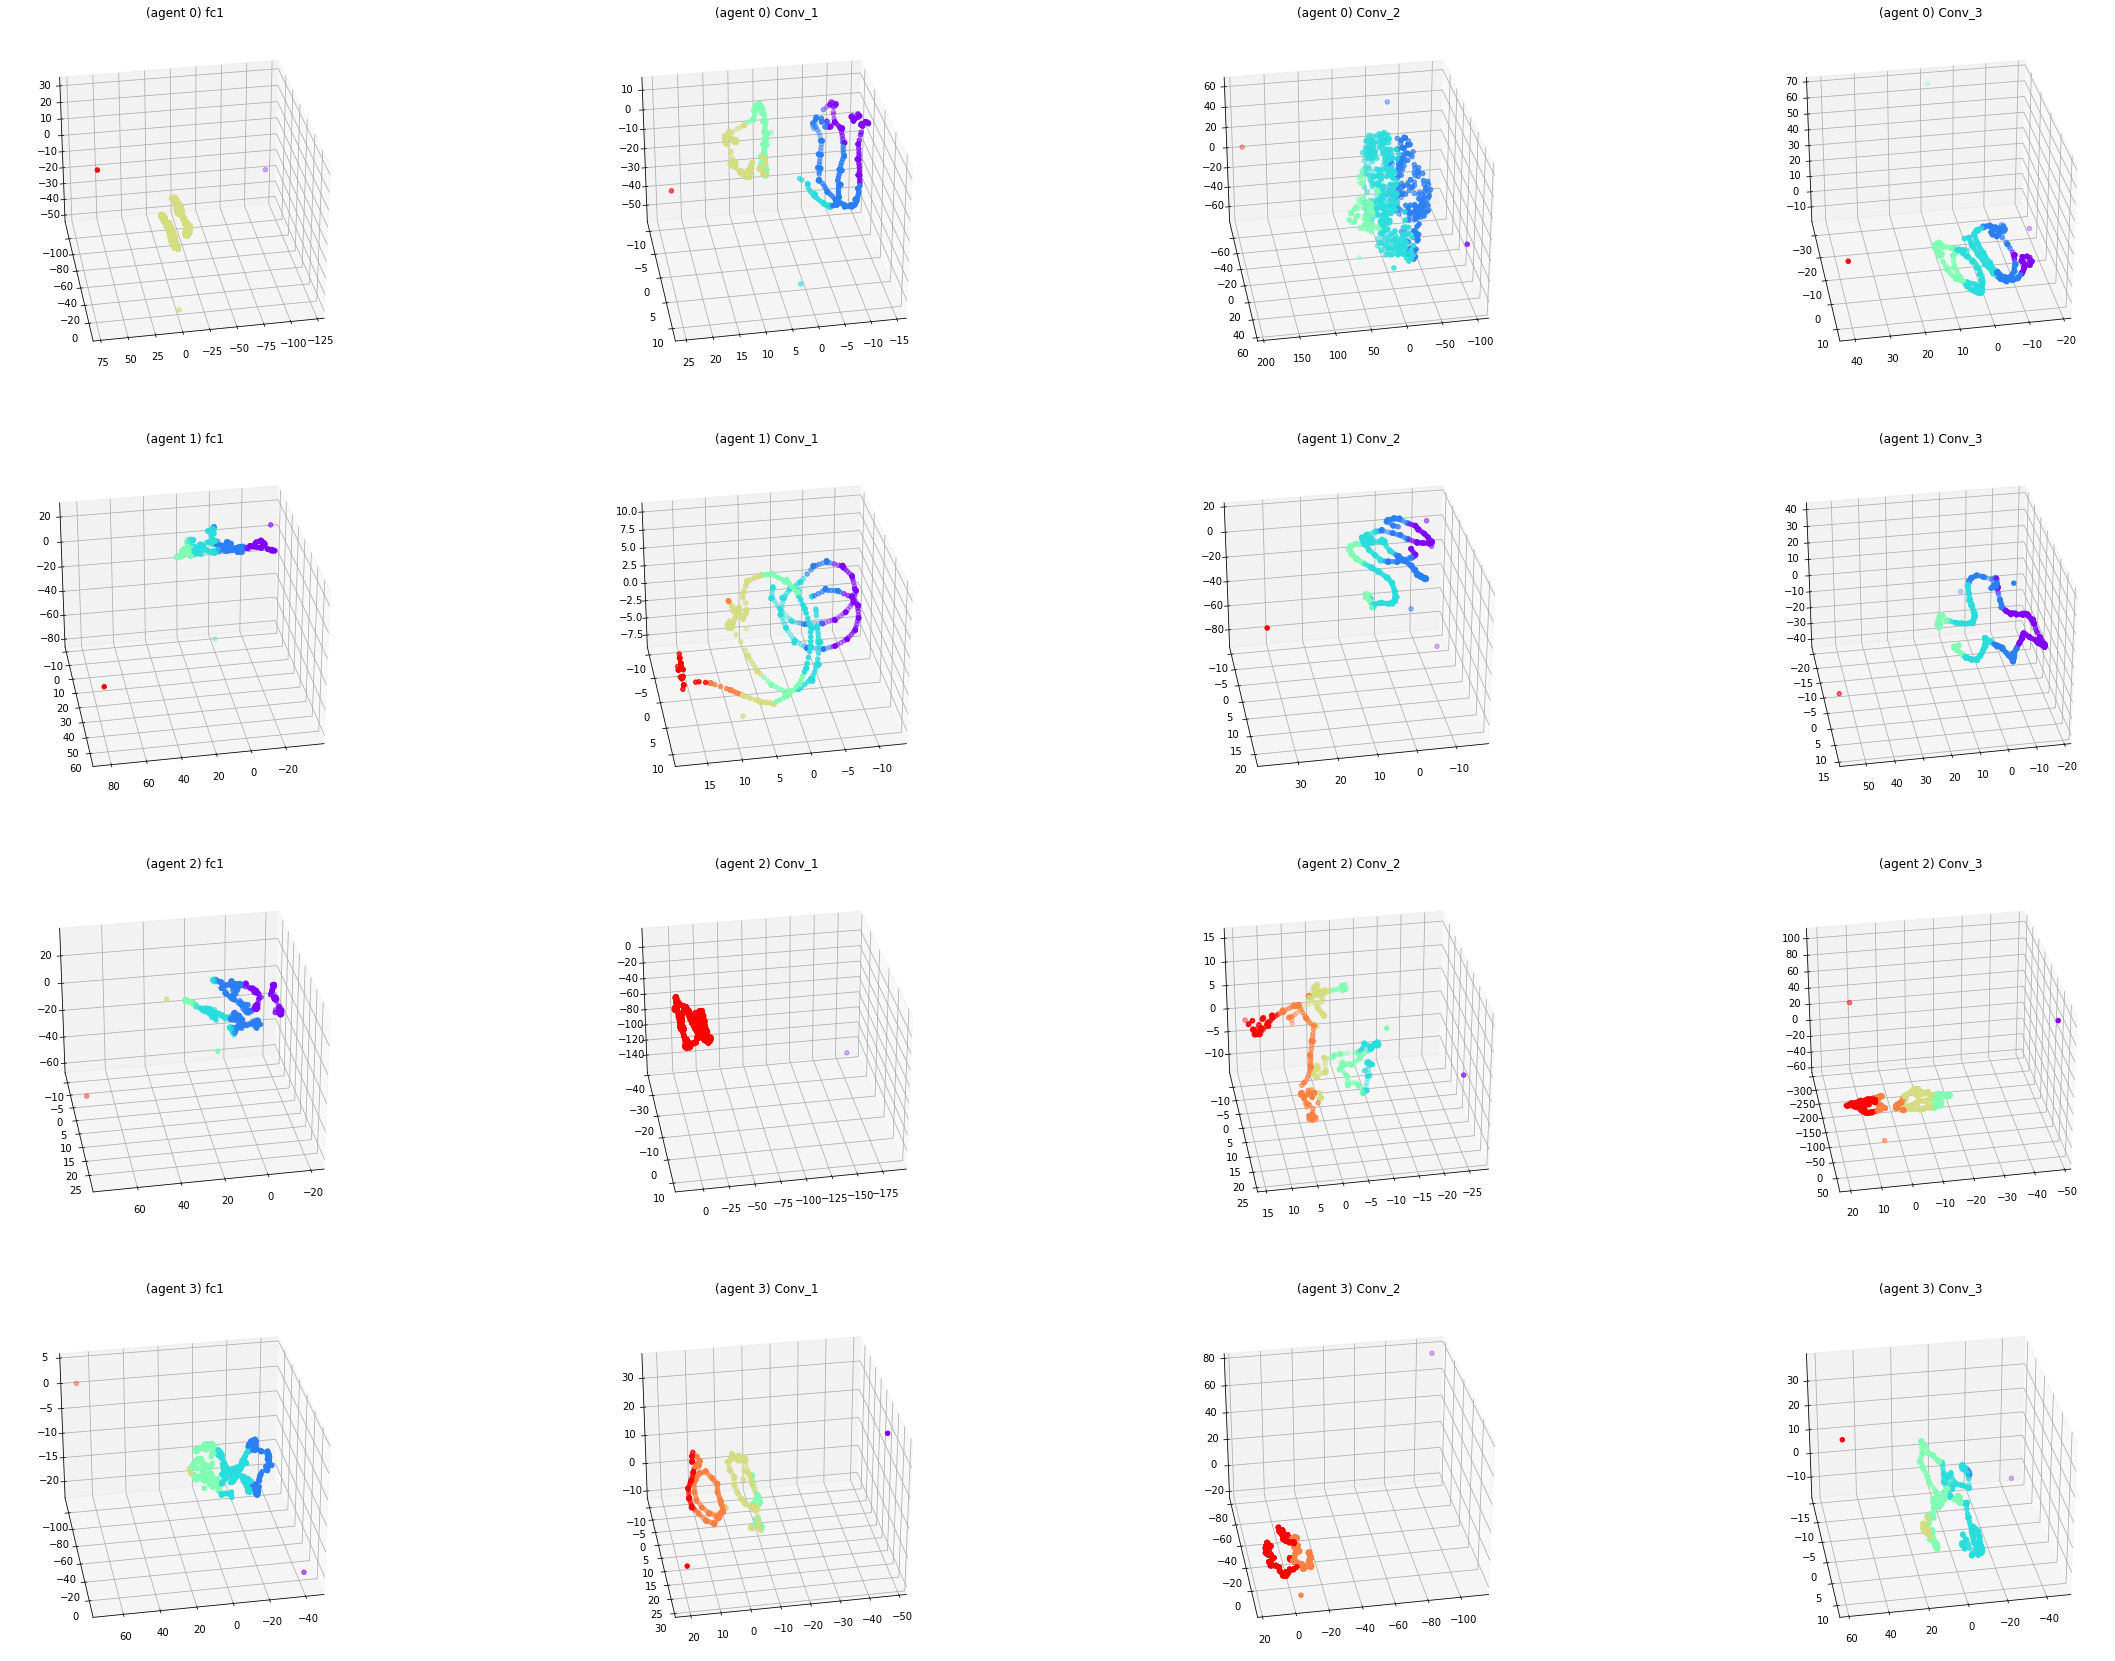

In [33]:
model = manifold.TSNE(n_components=3, init="pca", random_state=0)

i = 1
fig = plt.figure(figsize=(40, 30))
for agent_number in range(len(Liste_agents)):
    print("agent_number",agent_number)
    for layer in range(len(Names_hook)):
        activity_layer = analysis.prepro(Liste_activation[agent_number][layer])
        X  = model.fit_transform(activity_layer)
        colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))
        ax = fig.add_subplot(len(Liste_agents), len(Names_hook),i,projection='3d')
        sc = ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],**colorize)
        ax.view_init(azim=80, elev=30)
        ax.axis("tight")
        ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))
        i+=1
plt.show()

In [37]:
a = torch.tensor([2,3,4])
b = torch.tensor([2,3,4])

print(a+b)

tensor([4, 6, 8])
